# Automatic Traffic Recorders (ATR) 
# Identifying Extreme Values

In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

import datetime

## ATR Bikes
## Visualizing the dataset

In [19]:
sql_volumes = '''
SELECT volume_15min
FROM open_data.volumes_atr_bikes
'''
volumes = pandasql.read_sql(sql_volumes, con)

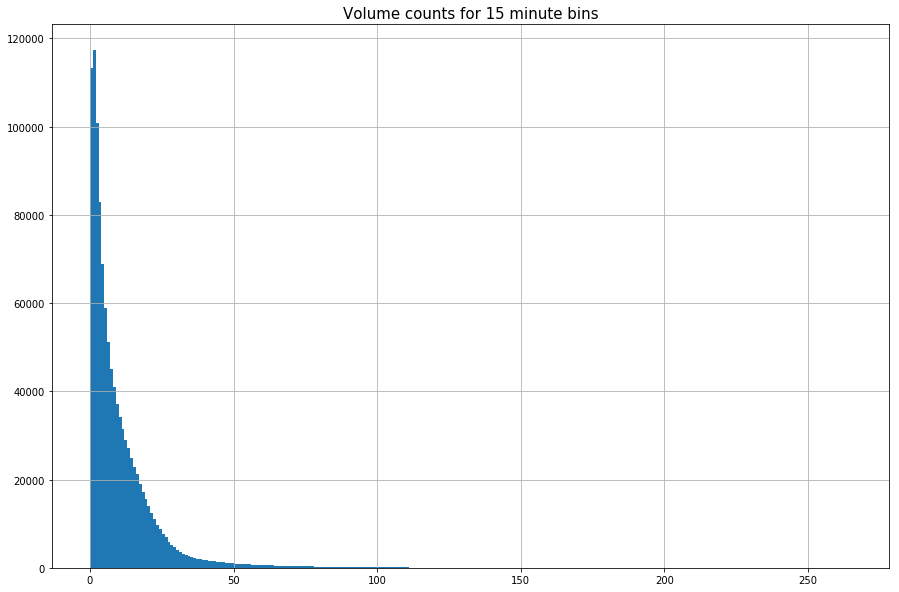

In [20]:
bin_val = np.arange(min(volumes['volume_15min']), max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

In [13]:
 max(volumes['volume_15min'])

266.0

## Removing outliers from the dataset

In [4]:
sql_volumes = '''
SELECT centreline_id, direction, location, class_type, datetime_bin, volume_15min 
FROM open_data.volumes_atr_bikes
'''

sql_locations = '''
SELECT DISTINCT ON (centreline_id, direction) centreline_id, direction
FROM open_data.volumes_atr_bikes
'''

locations = pandasql.read_sql(sql_locations, con)
volumes = pandasql.read_sql(sql_volumes, con)

In [43]:
final_df = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])
outliers = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['centreline_id'] == row.centreline_id) & (volumes['direction'] == row.direction) ]
    p25, p75 = np.percentile(subset['volume_15min'], 25), np.percentile(subset['volume_15min'], 75)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)


In [24]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

5.501458367927457

In [25]:
# QC checks
print((len(outliers.index) + len(final_df.index)) == len(volumes.index))

True


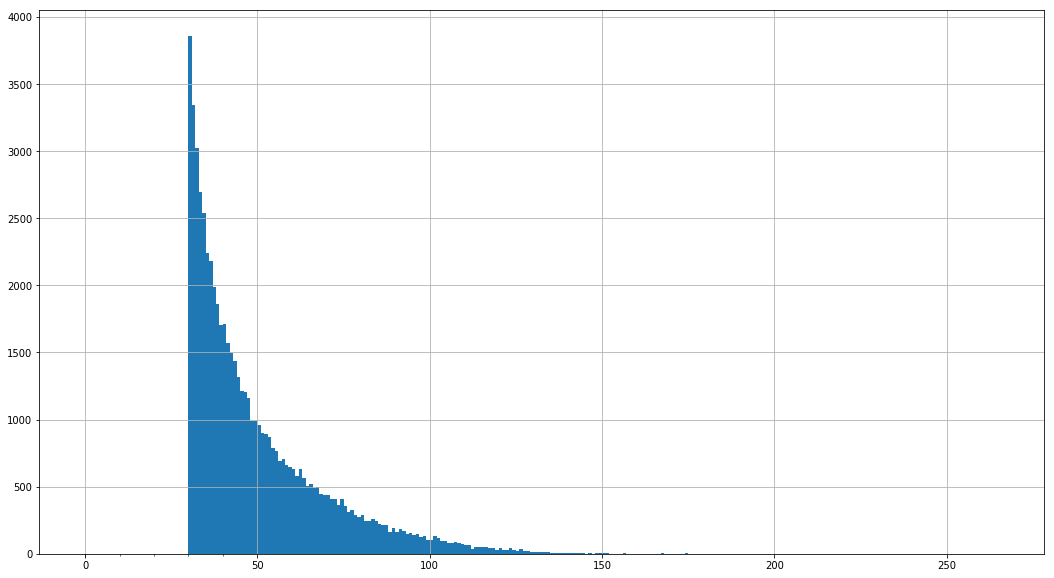

In [26]:
outliers['volume_15min'].hist(bins = np.arange(0, max(outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

In this case, the outliers are all higher values. However, these values do not seem very extreme and could potentially be attribiuted to the large variation of volumes across times of days and months. 

Investigate some of the larger outliers to see if they occur during rush hour, and see how much of the outliers in general occur during rush hour. I am checking if they occur during rush hour because there is generally higher volumes of traffic during rush hour. If most of the outliers with high volumes do not occur at rush hour, it may be evidence to prove that they are in fact extreme values (and vice versa).

In [77]:
# get all outliers that happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                          | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers with volumes over 100 (in comparison to all outliers with values over 100)
(len(subset_outlier_over100.index) / len(outliers.loc[(outliers['volume_15min'] > 100)]))*100

93.80188157166575

In [80]:
# get all outliers that happen at rush hour
subset_outlier_over100 = outliers.loc[( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                        | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers (in comparison to all outliers)
(len(subset_outlier_over100.index) / len(outliers))*100

66.94279949475894

In [81]:
# get all outliers that do not happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour != 9) 
                                                                          & (outliers['datetime_bin'].dt.hour != 8)
                                                                         & (outliers['datetime_bin'].dt.hour != 17)
                                                                         & (outliers['datetime_bin'].dt.hour != 16)
                                                                           & (outliers['datetime_bin'].dt.hour != 18))] 
                                    
subset_outlier_over100
#len(subset_outlier_over100.index)

,centreline_id,class_type,datetime_bin,direction,hour,location,month,volume_15min
179531,8540609,Cyclists,1997-11-03 06:15:00,Eastbound,6.0,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,11.0,102.0
612513,8540609,Cyclists,2007-10-12 13:00:00,Eastbound,13.0,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,10.0,116.0
669175,8540609,Cyclists,2010-06-18 15:45:00,Eastbound,15.0,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,6.0,106.0
904589,8540609,Cyclists,2014-04-23 12:15:00,Eastbound,12.0,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,4.0,120.0
57479,8540609,Cyclists,1995-08-16 07:30:00,Westbound,7.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,8.0,126.0
108913,8540609,Cyclists,1996-07-30 05:00:00,Westbound,5.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,7.0,203.0
180476,8540609,Cyclists,1997-11-08 04:15:00,Westbound,4.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,11.0,116.0
180482,8540609,Cyclists,1997-11-08 05:00:00,Westbound,5.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,11.0,128.0
180484,8540609,Cyclists,1997-11-08 05:15:00,Westbound,5.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,11.0,110.0
380344,8540609,Cyclists,2002-09-04 07:45:00,Westbound,7.0,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,9.0,102.0


Most of the highest values happen during rush hour, which makes their high values make sense. There are 112 cases where a volume is an outlier has a volume of over 100 but does not happen during rush hour.

### Explore modification to the IQR process
Try to modify the IQR process slightly to change the percentiles from 25 and 75 to 5 and 95 (I also tried 10 and 90, 5 and 90 but found this one to be the best). 

In [5]:
final_df = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])
outliers = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['centreline_id'] == row.centreline_id) & (volumes['direction'] == row.direction) ]
    p25, p75 = np.percentile(subset['volume_15min'], 5), np.percentile(subset['volume_15min'], 95)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)


In [39]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

0.5269437084419287

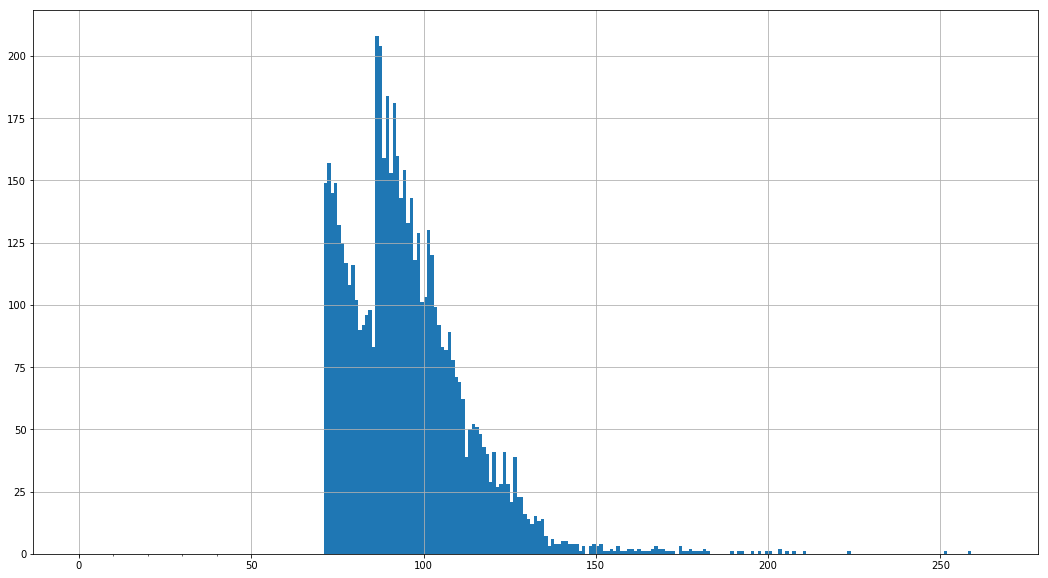

In [40]:
outliers['volume_15min'].hist(bins = np.arange(0, max(outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

In [6]:
# get all outliers that happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                          | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers with volumes over 100 (in comparison to all outliers with values over 100)
(len(subset_outlier_over100.index) / len(outliers.loc[(outliers['volume_15min'] > 100)]))*100

93.80188157166575

In [7]:
# get all outliers that happen at rush hour
subset_outlier_over100 = outliers.loc[( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                        | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers (in comparison to all outliers)
(len(subset_outlier_over100.index) / len(outliers))*100

93.18376434320945

In [10]:
# get all outliers that do not happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour != 9) 
                                                                          & (outliers['datetime_bin'].dt.hour != 8)
                                                                         & (outliers['datetime_bin'].dt.hour != 17)
                                                                         & (outliers['datetime_bin'].dt.hour != 16)
                                                                           & (outliers['datetime_bin'].dt.hour != 18))] 

# about 2% of outliers with volume over 100 do not occur at rush hour
(len(subset_outlier_over100.index) / len(outliers))*100

1.9181366672375406

A very large amount (over 90%) of the outliers in this case with the highest volumes occur during rush hour, which can explain why their volumes are so high. 

The majority of the outliers identified in this dataset occur during rush hour, and the highest volumes (i.e. 266) is about the same as the highest volume in the TMC bikes dataset. The number of volume counts decrease steadily as the volume increases, and there are no sparatic values. Therefore, **I do not think it makes sense to remove any of the records from the dataset**, as I do not believe any of them are "extreme values".  

# ATR Short-Term

## Visualizing the dataset

In [15]:
sql_volumes = '''
SELECT volume_15min
FROM open_data.volumes_atr_shortterm
'''
volumes = pandasql.read_sql(sql_volumes, con)

(0, 150000)

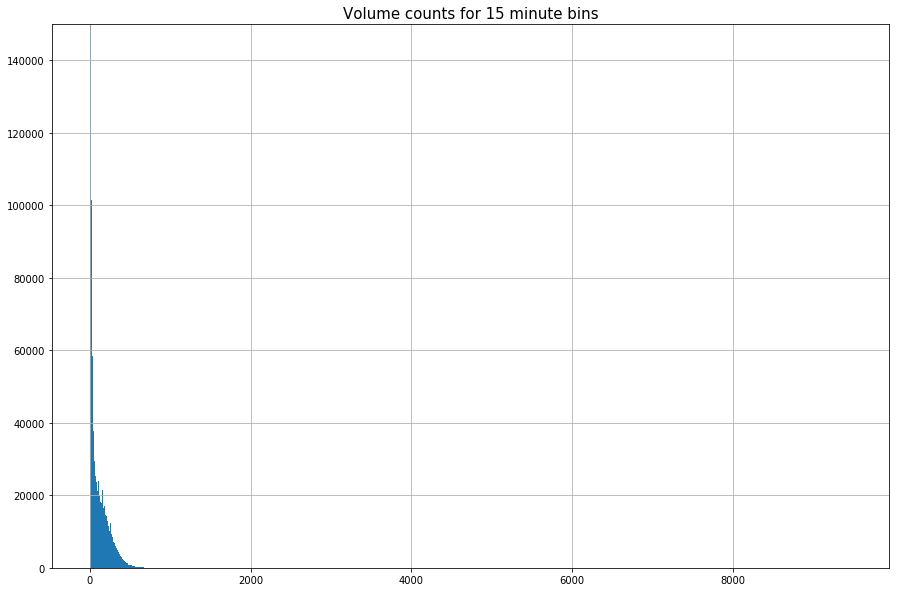

In [20]:
bin_val = np.arange(min(volumes['volume_15min']), max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)
plt.ylim(0, 150000)

In [17]:
max(volumes['volume_15min'])

9472.0

The maximum volume is extremely high. I am going to look into this record and other records with very high volumes.

In [22]:
sql_high_volumes = '''
SELECT * 
FROM open_data.volumes_atr_shortterm
WHERE volume_15min = 9472;
'''
pandasql.read_sql(sql_high_volumes, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,14066690,Southbound,CHERRY ST S/B N OF COMMISSIONERS ST,Vehicles,2000-06-14 02:45:00,9472.0


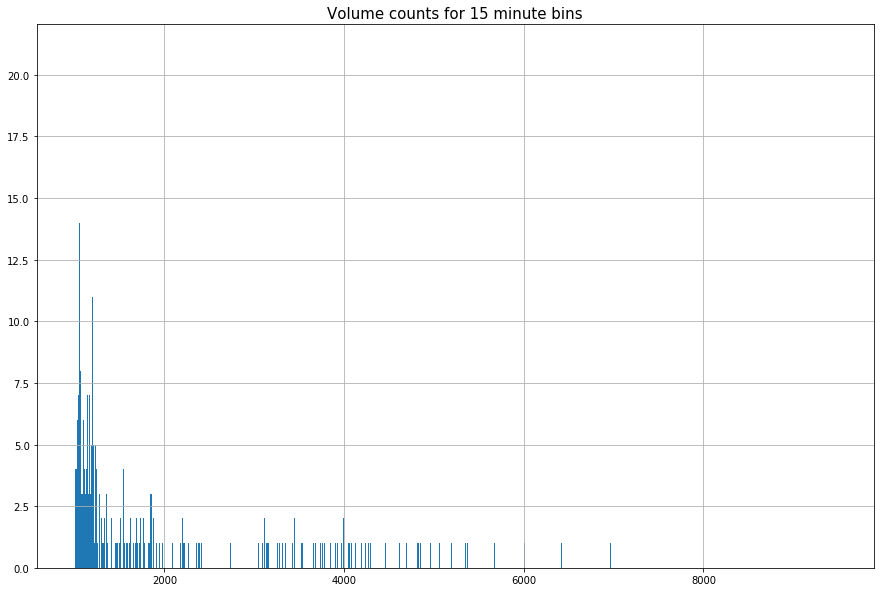

In [23]:
bin_val = np.arange(1000, max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

The TMC datasets had a maximum 15 min volume of under 2000. Some of the values in this dataset look very high for a 15 minute period.  

In [2]:
sql_high_volumes = '''
SELECT DISTINCT centreline_id, location, COUNT(*), AVG(volume_15min) avg_volume
FROM open_data.volumes_atr_shortterm
WHERE volume_15min > 2000
GROUP BY centreline_id, location;
'''
pandasql.read_sql(sql_high_volumes, con)

,centreline_id,location,count,avg_volume
0,1098.0,DON VALLEY PKWY N/B S OF LEASIDE BRIDGE,18,3542.611111
1,105198.0,BRIMLEY RD N/B S OF CHARTLAND BLVD S,7,2382.000000
2,106862.0,MCCOWAN RD S/B N OF HIGHWAY 401 N TCS,2,2280.500000
3,107148.0,MCCOWAN RD S/B N OF HIGHWAY 401 S TCS,1,2153.000000
4,107973.0,WARDEN AVE N/B S OF ARKONA DR,1,2200.000000
5,108096.0,WARDEN AVE N/B S OF HIGHWAY 401 N TCS,1,2200.000000
6,438309.0,BAYVIEW AVE S/B N OF EMPRESS AVE,1,2033.000000
7,438310.0,HIGHWAY 404 S/B S OF SHEPPARD AVE,37,5100.243243
8,439358.0,HIGHWAY 404 N/B TO HIGHWAY 401 E/B,4,2131.000000
9,439697.0,BAYVIEW AVE S/B N OF HIGHWAY 401 S TCS,1,2021.000000


A lot of these really high volumes seem to be on taken on highways. Highways have higher speeds and so their volumes of traffic may be a lot larger than on normal city roads. However, some of these appear to be normal roadways, so some of these may be extreme values. 

I created a view with all of the outliers for ATR short term dataset called `open_data.atr_shortterm_outliers`. The code that created the view was:

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location, l.direction, calc.lower, calc.upper
FROM 
(SELECT DISTINCT ON (location, centreline_id, direction) centreline_id, location, direction
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, 
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*1.5)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*1.5) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, centreline_id, direction
) AS calc ON calc.location = l.location AND calc.direction = l.direction ) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;
```

In [6]:
sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers
'''

outliers = pandasql.read_sql(sql_outliers, con)

In [5]:
sql_volumes = '''
SELECT * FROM open_data.volumes_atr_shortterm
'''

volumes = pandasql.read_sql(sql_volumes, con)

In [5]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

1.1774664391086593

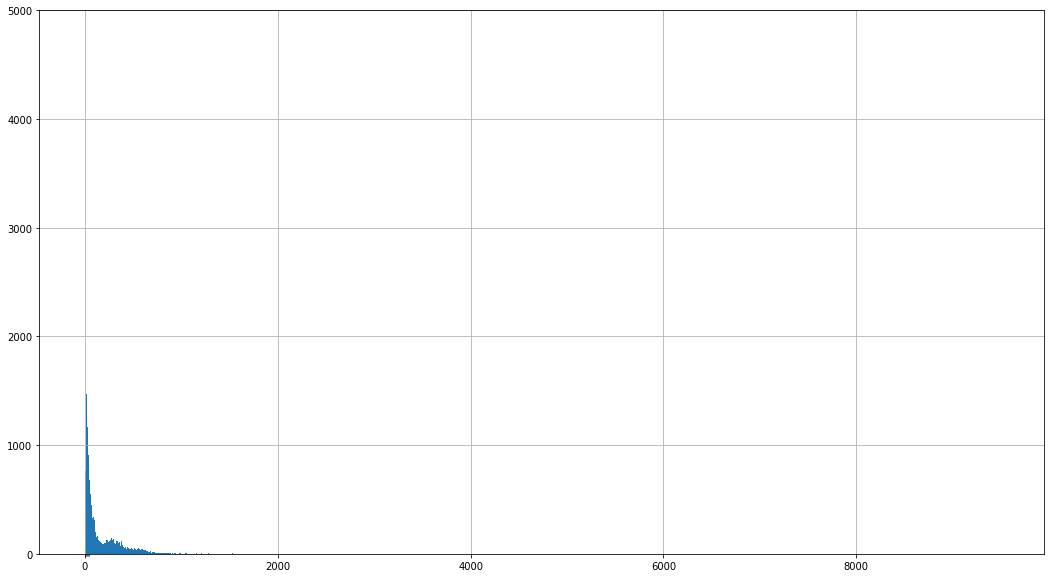

In [6]:
outliers['volume_15min'].hist(bins = np.arange(min(outliers['volume_15min']), max(outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

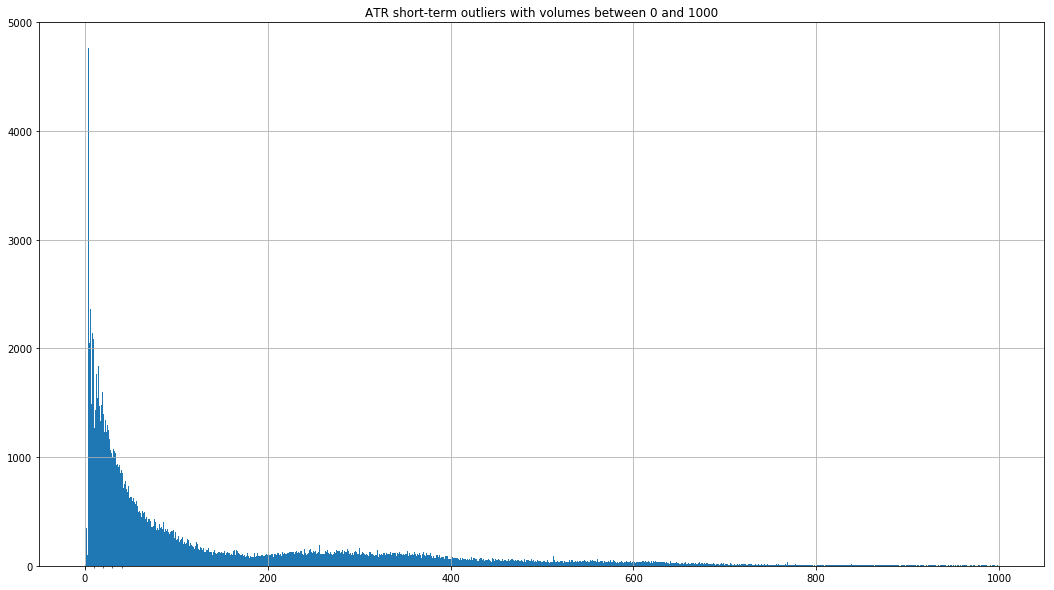

In [7]:
outliers['volume_15min'].hist(bins = np.arange(0, 1000, 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

plt.title("ATR short-term outliers with volumes between 0 and 1000")
#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

There ara a lot of volume values that are low and are not really "exteme" values for volumes. I investigated some of the intersections where the volumes under 5 occured, and they were not major streets, so the values are logical. 

Try modifying the IQR process by using different values for k, I used 2, 2.5, and 3 as k values. Below is the code and analysis of the outliers when the k-value was equal to 3.

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers_k3;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers_k3 AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location,  l.direction, calc.lower, calc.upper
FROM 
(SELECT DISTINCT ON (centreline_id, location, direction) centreline_id, location, direction
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, 
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY centreline_id, location, direction
) AS calc ON calc.location = l.location AND calc.direction = l.direction ) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;
```

In [8]:
sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers_k3
'''

outliers_k2 = pandasql.read_sql(sql_outliers, con)

In [14]:
# get percentage of total records that are outliers 
(len(outliers_k2.index) / len(volumes.index))*100 

0.22276871204442786

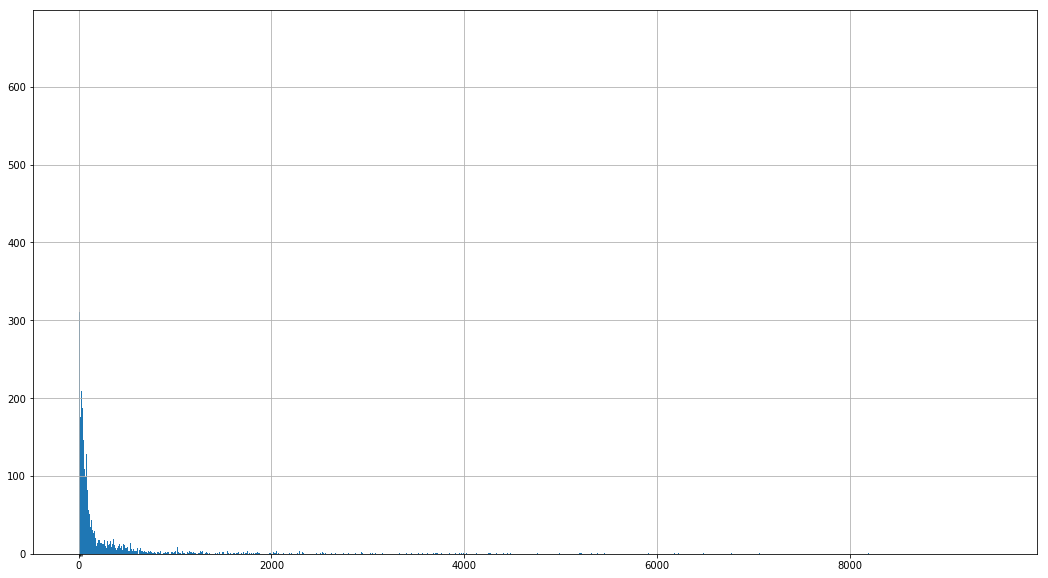

In [9]:
outliers_k2['volume_15min'].hist(bins = np.arange(min(outliers_k2['volume_15min']), max(outliers_k2['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

ax.set_xticks(minor_ticks, minor=True)

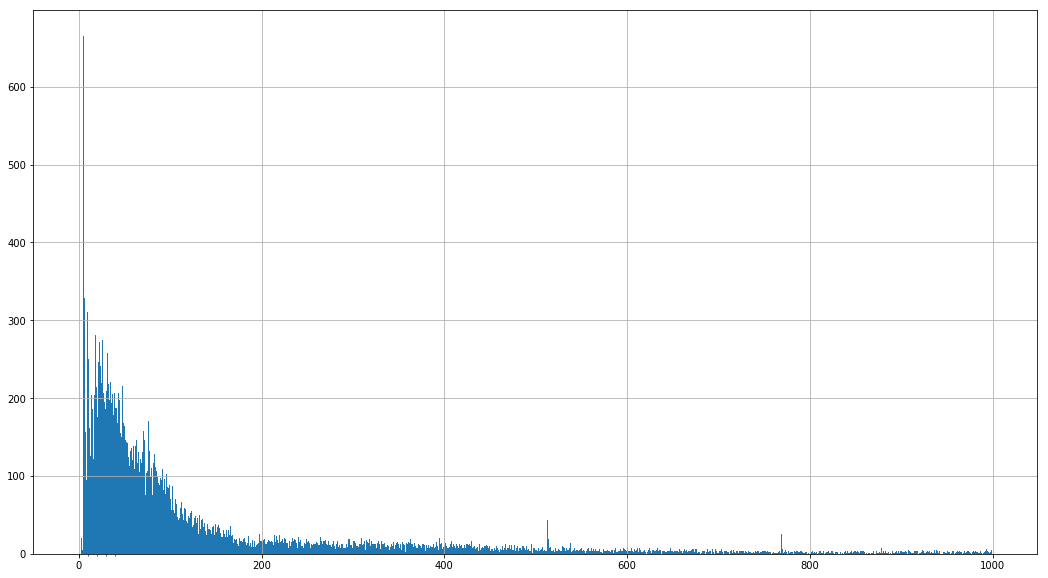

In [10]:
outliers_k2['volume_15min'].hist(bins = np.arange(0, 1000 , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

ax.set_xticks(minor_ticks, minor=True)

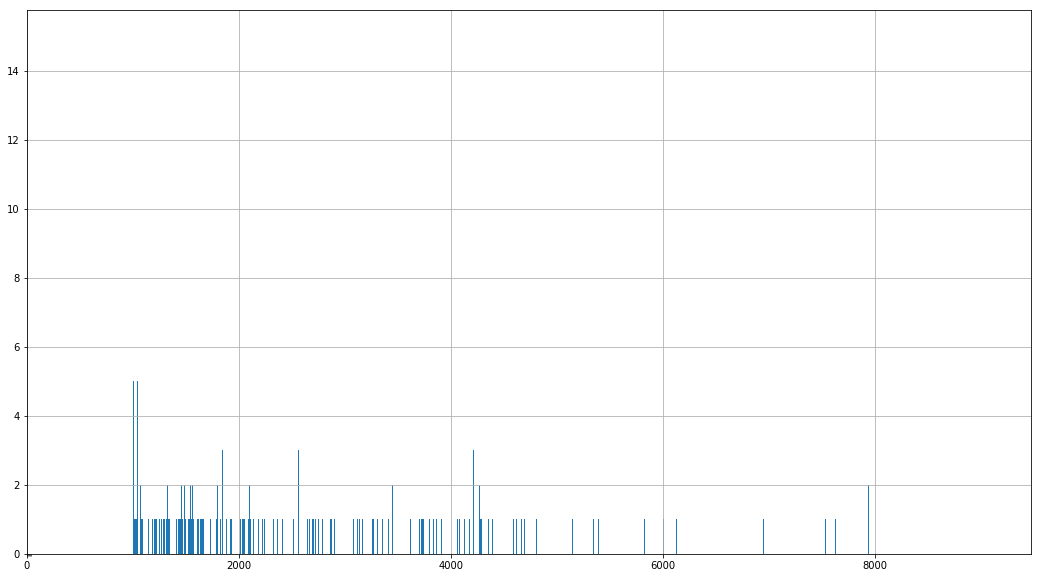

In [11]:
outliers_k2['volume_15min'].hist(bins = np.arange(1000,  max(outliers_k2['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(1000,  max(outliers_k2['volume_15min']))
ax.set_xticks(minor_ticks, minor=True)

In [ ]:
sql_over200_locations = '''
SELECT location, COUNT(*) FROM open_data.atr_shortterm_outliers_k3 WHERE volume_15min > 2000 GROUP BY location
'''
pandasql.read_sql(sql_over200_locations, con)

Look into outliers with very low volumes by seeing if these low values are true outliers or if they are part of the distribution.

In [12]:
sql = '''
-- check out upper and lower values
SELECT DISTINCT l.location, l.direction, calc.lower, calc.upper
FROM 
(SELECT DISTINCT ON (location, direction) centreline_id, direction
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT location, direction, 
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, direction) AS calc ON calc.location = l.location AND calc.direction = l.direction
WHERE l.location = 7439 AND l.direction = 'Eastbound'

'''

pandasql.read_sql(sql, con)

,centreline_id,direction,lower,upper
0,7439,Eastbound,-3.0,4.0


In [29]:
sql_volumes7429 = '''
SELECT * FROM open_data.volumes_atr_shortterm
WHERE centreline_id = 7439
'''

volumes_7439 = pandasql.read_sql(sql_volumes7429, con)
# add hour column
def get_hour(row):
    return row['datetime_bin'].hour

volumes7439['hour'] = volumes7439.apply(lambda row:  get_hour (row), axis=1)  


sql_outliers7429 = '''
SELECT * FROM open_data.atr_shortterm_outliers
WHERE centreline_id = 7439
'''

outliers_7439 = pandasql.read_sql(sql_outliers7429, con)

outliers7439['hour'] = outliers7439.apply(lambda row:  get_hour (row), axis=1)  


sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers_k3
WHERE centreline_id = 7439
'''
k7439 = pandasql.read_sql(sql_outliers, con)

k7439['hour'] = k7439.apply(lambda row:  get_hour (row), axis=1)  


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


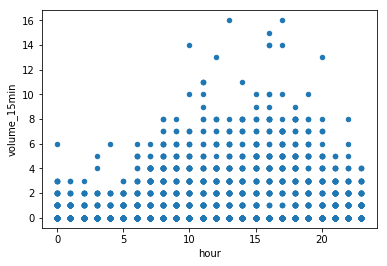

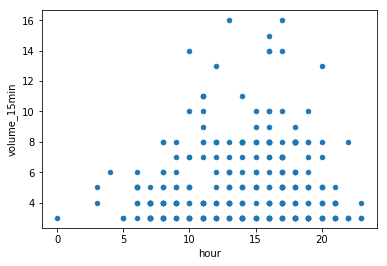

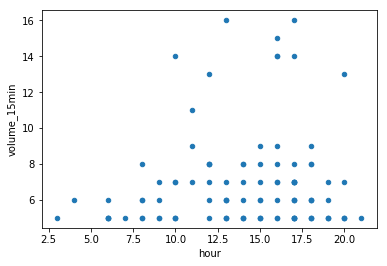

In [30]:
volumes7439.plot.scatter(x='hour', y='volume_15min')
outliers7439.plot.scatter('hour', 'volume_15min')
k7439.plot.scatter('hour', 'volume_15min')

Some/most of the points in both of the last two plots were not true outliers, as they occur within the general distribution of the first scatter plot. On the plus side, the true outliers were included in both plots. 

Try to edit the outlier criteria by looking at outliers by location, direction (like before) and additionally class type (i.e. Pedestrians, Cyclists, etc.). See if this change effects the validity of the outliers being defined.

Code: 
```sql 

DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers_class;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers_class AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location, l.direction, calc.lower, calc.upper, l.class_type
FROM 
(SELECT DISTINCT ON (location, centreline_id, direction, class_type) centreline_id, location, direction, class_type
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, class_type,
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.95) within group (order by volume_15min asc) - percentile_cont(0.05) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.95) within group (order by volume_15min asc) - percentile_cont(0.05) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, centreline_id, direction, class_type
) AS calc ON calc.location = l.location AND calc.direction = l.direction AND calc.class_type = l.class_type) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction AND o.class_type = lu.class_type

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;


```

In [2]:
sql_outliers = '''
SELECT * 
FROM open_data.volumes_atr_shortterm_remove0
'''

outliers_class = pandasql.read_sql(sql_outliers, con)

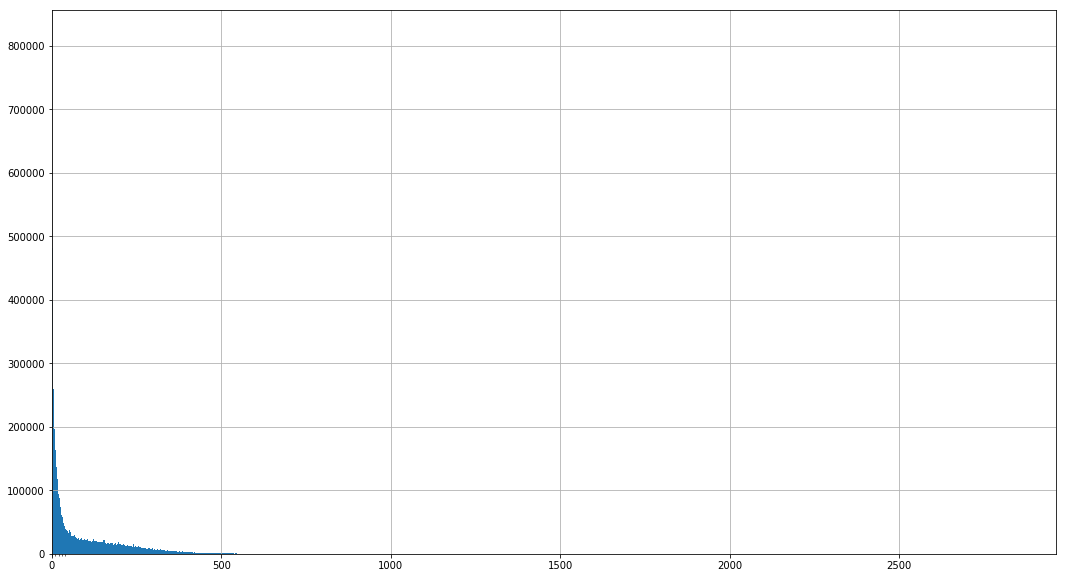

In [3]:
outliers_class['volume_15min'].hist(bins = np.arange(min(outliers_class['volume_15min']), max(outliers_class['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(min(outliers_class['volume_15min']), max(outliers_class['volume_15min']))

ax.set_xticks(minor_ticks, minor=True)

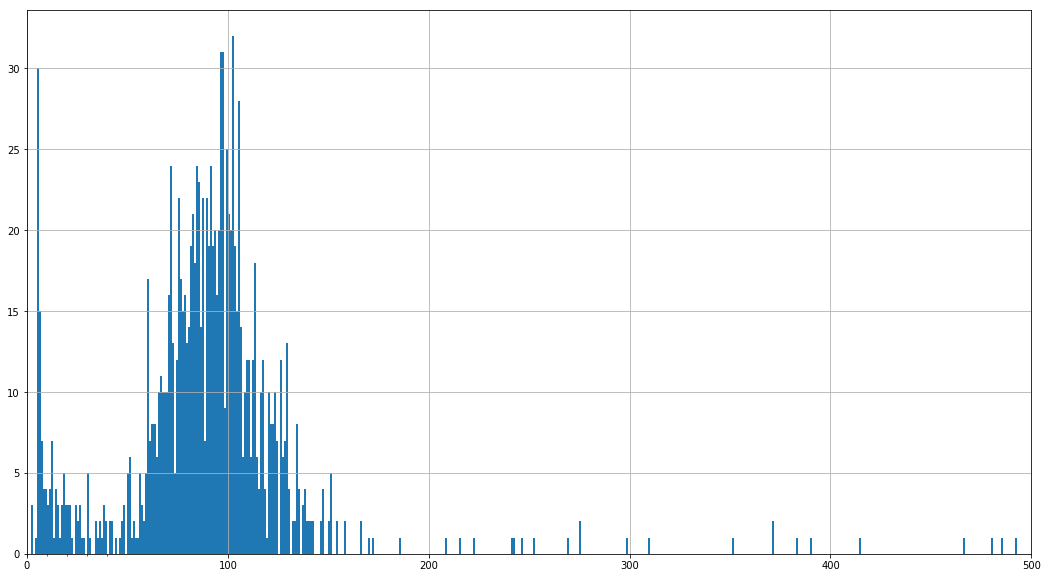

In [41]:
outliers_class['volume_15min'].hist(bins = np.arange(min(outliers_class['volume_15min']), max(outliers_class['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(0,500)

ax.set_xticks(minor_ticks, minor=True)

As you can see from the above histograms and scatter plot, the same phenomenon where low values that are in and around 0 are being classified as outliers. These values may be outliers, but they are definitely not extreme values. 

The next approach to remove extreme values that I tried was completely different than the first few. When looking over the dataset, it was noticed that there are a lot of volumes of 0 that should not be 0, followed by an extremely large volume. I started by creating an exceptions view that contained all of the records that occur on days and at locations where there exists a value of 0 and a value above 20 within an hour of each other. After that, I realized that there were still some extreme values in the dataset. I then refined the query that created the exceptions view to include records that occur on dates and at locations where there was a volume of under 450 and a volume of over 1000 wihtin an hour of each other. Additionally, the exceptions view also includes date-location combinations that have less than or equal to 3 records and have a maximum value that is extremely high (over 1000) or a minimum volume of under 5, and date-location combinations where the maximum volume is 0 or the average volume is 0. 

The code to create the view: 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_shortterm_exceptions;
CREATE MATERIALIZED VIEW  open_data.volumes_atr_shortterm_exceptions AS 
(
-- get day/locations where there exists a value of 0 and a value above 20 within an hour of each other. 
-- Also get days that have a volume of under 450 and a volume of over 1000 wihtin an hour of each other
SELECT o1.datetime_bin::date, o1.location 
FROM open_data.volumes_atr_shortterm o1 JOIN open_data.volumes_atr_shortterm o2 ON o1.location = o2.location  
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' 
AND ((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000) ) 

UNION 

(SELECT o2.datetime_bin::date, o2.location FROM open_data.volumes_atr_shortterm o1 JOIN open_data.volumes_atr_shortterm o2 ON o1.location = o2.location 
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' AND 
((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000))  )

 
UNION 

-- get days that only have less than 3 records for a location+date and a max value that is strangley high or a mininum value for that location+date that is extremely low
(
SELECT datetime_bin::DATE, location
FROM open_data.volumes_atr_shortterm v
GROUP BY datetime_bin::DATE, location
-- CHANGE MAX TO OVER 1000 ??? WOULD HELP IN BURNHAMTHORPE AND RENFORTH THING and etobicoke creek/bloor 
HAVING (COUNT(*) <= 3 AND (MAX(volume_15min) > 1000 OR MIN(volume_15min) <= 5)) OR AVG(volume_15min) = 0
)

);
```

## QA/QC checks 

In order to make sure all of the extreme values were identified and that the values in the exception table are extreme (or occur on the same day as extreme values), I did extensive QA/QC. 

In [6]:
sql = '''
-- max that is not in exceptions table is 1359
SELECT MAX(volume_15min) 
FROM open_data.volumes_atr_shortterm 
WHERE location NOT IN 
(SELECT location FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND datetime_bin::DATE NOT IN 
(SELECT datetime_bin FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
'''

pandasql.read_sql(sql, con)

,max
0,1359.0


In [7]:
# look at values that are not in exceptions table but are over 1000
# I checked quite a few (a bit under 10) of the locations here by running queries such as:
# SELECT * FROM open_data.volumes_atr_shortterm WHERE location = 'EGLINTON AVE W/B W OF MARTIN GROVE RD'
# I found that the volume values gradually increase, reach above 1000, and then gradually decrease 
# so I have no reason to believe that these values over 1000 are extreme values
sql = '''
SELECT * 
FROM open_data.volumes_atr_shortterm 
WHERE location NOT IN 
(SELECT location FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND datetime_bin::DATE NOT IN 
(SELECT datetime_bin FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND volume_15min > 1000
'''

pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 07:30:00,1008.0
1,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 07:45:00,1058.0
2,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:00:00,1178.0
3,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:15:00,1258.0
4,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:30:00,1216.0
5,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:45:00,1118.0
6,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 09:00:00,1034.0
7,7273868.0,Southbound,YONGE ST S/B S MERTON ST,Vehicles,2002-08-02 08:00:00,1054.0
8,7273868.0,Southbound,YONGE ST S/B S MERTON ST,Vehicles,2002-08-02 08:15:00,1296.0
9,7273868.0,Southbound,YONGE ST S/B S MERTON ST,Vehicles,2002-08-02 08:30:00,1358.0


In [14]:
# look at other really high volumes that are not over 1000 and not in the exceptions table 
# I looked at a lot (around 5) of these date-location combinations randomly 
# and the progression to a large value (800-1000) was normal (i.e. gradually increase to large value(s) then gradually decrease)
sql = '''
SELECT * 
FROM open_data.volumes_atr_shortterm 
WHERE location 
NOT IN (SELECT DISTINCT location FROM open_data.volumes_atr_shortterm_exceptions) 
AND volume_15min > 800 AND volume_15min < 1000 
ORDER BY location, datetime_bin
LIMIT 1000
'''
pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,NaN,Southbound,427 S/B TO THE QUEENSWAY W/B,Vehicles,1996-06-27 17:15:00,892.0
1,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 12:45:00,828.0
2,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 13:00:00,811.0
3,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 13:15:00,867.0
4,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 16:45:00,877.0
5,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 17:30:00,845.0
6,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 17:45:00,801.0
7,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:15:00,873.0
8,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:30:00,914.0
9,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:45:00,801.0


In [10]:
# Find the number of records over the value of 1000 that are not in the exceptions table
# Most of them are in the exceptions table
# there are some values over 1000 that are not in the exceptions table
# this would make sense because some volumes are taken on highways or large/busy roads
# also road/highway closures could potentially affect traffic volumes on certain streets/highways
sql = '''
SELECT 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 1000) cnt_exceptions,
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 1000) cnt, 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 1000) - 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 1000) cnt_diff
'''
pandasql.read_sql(sql, con)

,cnt_exceptions,cnt,cnt_diff
0,2291,2758,467


In [11]:
# All the volumes over 2000 are classified as exceptions
# These values are definitely extreme values so this is good
sql = '''
SELECT 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 2000) cnt_exceptions,
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 2000) cnt, 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 2000) - 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 2000) cnt_diff
'''
pandasql.read_sql(sql, con)

,cnt_exceptions,cnt,cnt_diff
0,759,759,0


In [12]:
# this query looks at the locations where there are very low average volumes 
# There are some locations with an average volume of 0 
# I made sure the records with that location and an average volume of zero were in the exceptions table
# I looked at some all records for some locations with very low averages 
# they all seemed to make enough sense, even the locations with an average volume under 1
# I kept these values out of the exceptions table because I did not have enough evidence to prove that they were extreme values
# most of these locations with small averages were streets in residential areas

sql = '''
SELECT DISTINCT location, AVG(volume_15min), MAX(volume_15min), COUNT(*) 
FROM open_data.volumes_atr_shortterm o 
GROUP BY location 
HAVING AVG(volume_15min) < 3 
ORDER BY AVG(volume_15min)
'''
pandasql.read_sql(sql, con)

,location,avg,max,count
0,AILEEN AVE W/B E OF KEELE ST,0.000000,0.0,96
1,ANGLESEY BLVD W/B E OF LAMBETH CRES,0.000000,0.0,96
2,BEATY AVE N/B S OF QUEEN ST,0.000000,0.0,288
3,BROOKSIDE AVE N/B N OF ST MARKS RD,0.000000,0.0,288
4,CALLENDER ST N/B S OF HARVARD AVE,0.000000,0.0,288
5,DANFORTH RD W/B W OF NESTON RD,0.000000,0.0,96
6,EATON AVE S/B N OF DANFORTH AVE,0.000000,0.0,288
7,FERN AVE E/B E OF SUNNYSIDE AVE,0.000000,0.0,288
8,GARDEN AVE E/B E OF GLENDALE AVE,0.000000,0.0,288
9,GARDEN AVE E/B E OF INDIAN RD,0.000000,0.0,288


## Creating the final view

Use the exceptions view create the final `open_data.volumes_atr_shortterm` view. 
```sql 
CREATE OR REPLACE VIEW open_data.volumes_atr_shortterm AS 
 SELECT flow_atr.centreline_id,
    flow_atr.direction,
    flow_atr.location,
    flow_atr.class_type,
    flow_atr.datetime_bin,
    flow_atr.volume_15min
   FROM open_data.flow_atr
  WHERE flow_atr.station_type = 'Short Term'::text AND flow_atr.volume_15min >= 0::numeric 
  AND NOT (EXISTS ( SELECT * 
           FROM open_data.volumes_atr_shortterm_exceptions exceptions
          WHERE exceptions.datetime_bin::date = flow_atr.datetime_bin::date AND exceptions.location::text = flow_atr.location::text));
```

# ATR Permanent

In [ ]:
sql_volumes_perm = '''
SELECT volume_15min
FROM open_data.volumes_atr_permanent
'''
volumes_perm = pandasql.read_sql(sql_volumes_perm, con) 

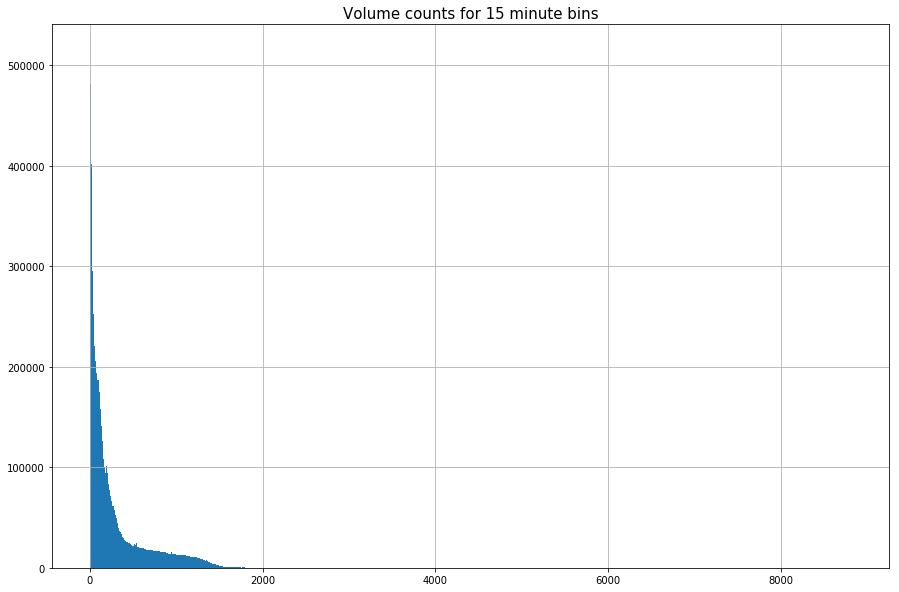

In [4]:
bin_val = np.arange(min(volumes_perm['volume_15min']), max(volumes_perm['volume_15min']), 1)

volumes_perm.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)


Above is the distribution of the volume data (15 minute bins) for dataset `open_data.volumes_atr_permanent`. As you can see (or maybe can't see from the above histogram), there are a lot of values that are some values that are above 2000. The highest value in the dataset is 8815, and there are 2575 entries with a volume of over 2000. These values are so high, they must be incorrect. I need to get rid of records in the dataset that are extreme values (i.e. incorrect values).

In [3]:
# look at Cyclist statistics
# the maximum value is reasonable 
sql = '''
SELECT MAX(volume_15min) 
FROM open_data.volumes_atr_permanent
WHERE class_type = 'Cyclists';
'''
pandasql.read_sql(sql, con) 

,max
0,266.0


In [7]:
sql_bikes = '''
SELECT volume_15min 
FROM open_data.volumes_atr_permanent
WHERE class_type = 'Cyclists';
'''
bikes = pandasql.read_sql(sql_bikes, con)

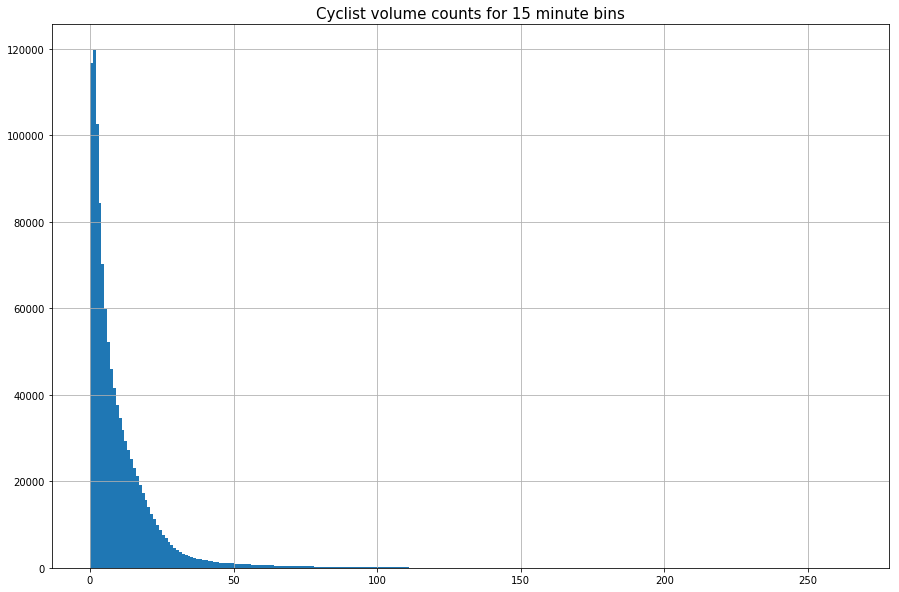

In [8]:
bin_val = np.arange(min(bikes['volume_15min']), max(bikes['volume_15min']), 1)

bikes.hist(bins=bin_val, figsize=(15,10))
plt.title('Cyclist volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)


None of the Cyclist counts seem to be extreme values. It is quite normal to assume that there would be a high number of 0 or low count values, since cycling is not as popular of a form of transportation duing certain seasons, weather conditions, or times of days. 

## Unsuccessful attempts at finding extreme values 

First, I will try the same approach that was used with the ATR short term dataset. The code I used to create the exceptions table: 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE MATERIALIZED VIEW  open_data.volumes_atr_permanent_exceptions AS 
(
-- get day/locations where there exists a value of 0 and a value above 20 within an hour of each other. 
-- Also get days that have a volume of under 450 and a volume of over 1000 wihtin an hour of each other
SELECT o1.datetime_bin::date, o1.location 
FROM open_data.volumes_atr_permanent o1 JOIN open_data.volumes_atr_permanent o2 ON o1.location = o2.location  
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' 
AND ((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000) ) 

UNION 

(SELECT o2.datetime_bin::date, o2.location FROM open_data.volumes_atr_permanent o1 JOIN open_data.volumes_atr_permanent o2 ON o1.location = o2.location 
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' AND 
((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000))  )


UNION 
-- get days that only have less than 3 records for a location+date and a max value that is strangley high or a mininum value for that location+date that is extremely low
(
SELECT datetime_bin::DATE, location
FROM open_data.volumes_atr_permanent v
GROUP BY datetime_bin::DATE, location
-- CHANGE MAX TO OVER 1000 ??? WOULD HELP IN BURNHAMTHORPE AND RENFORTH THING and etobicoke creek/bloor 
HAVING (COUNT(*) <= 3 AND (MAX(volume_15min) > 1000 OR MIN(volume_15min) <= 5)) OR AVG(volume_15min) = 0
)

);

```
This ran for over 18 hours before the execution was terminated ... it took way too long. 


The next try was an approach that got rid of the double joining. I made a view of every hour-location combination and got the average, median, max, min, count for each combination for weekdays, weekends and holidays. Then I made a second view which got the distinct dates that have a record that has a value of 0 and a hourly median of over 20, and the dates where there are volumes that are 3 times the hourly median (which I know is a condition that is way too arbitrary and was going to change later).

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_hour_location_avg;
-- Get the min, max, median, avg of each location-hour combination for weekdays, holidays and weekends
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_hour_location_avg AS (
SELECT weekend.location AS location, weekend.hour AS hour, avg_weekday, max_weekday, min_weekday, median_weekday, count_weekday, 
avg_weekend, max_weekend,  min_weekend, median_weekend, count_weekend, 
 avg_holiday, max_holiday, min_holiday, median_holiday,count_holiday

FROM 

(
	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_weekday, MAX(volume_15min) max_weekday, MIN(volume_15min) min_weekday, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_weekday, COUNT(*) AS count_weekday
	FROM open_data.volumes_atr_permanent
	WHERE date_part('dow', datetime_bin) in (1,2,3,4,5)
	AND datetime_bin::DATE NOT IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	
) AS weekday 

JOIN 


(
	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_weekend, MAX(volume_15min) max_weekend, MIN(volume_15min) min_weekend, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_weekend, COUNT(*) AS count_weekend
	FROM open_data.volumes_atr_permanent
	WHERE date_part('dow', datetime_bin) in (0, 6)
	AND datetime_bin::DATE NOT IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	


) AS weekend

ON weekday.location = weekend.location AND weekday.hour = weekend.hour

JOIN

(

	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_holiday, MAX(volume_15min) max_holiday, MIN(volume_15min) min_holiday, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_holiday, COUNT(*) AS count_holiday
	FROM open_data.volumes_atr_permanent
	WHERE datetime_bin::DATE IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	

) AS holiday 

ON  weekend.location = holiday.location  AND weekend.hour = holiday.hour
);


-- get the values that are off from avgs/appropriate mins/max's

CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM open_data.volumes_atr_permanent o
WHERE 

 -- a value of zero and a median hour/location/(weekend holiday weekday) combination with a value above 20
	(
	volume_15min = 0 
	AND   (
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 3*(
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		)


	)

);

```

This was left to run over night and ran for about 11 hours. 

I decided to check the approach by running some basic QA/QC . 


Not all of the records with values over 2000 are in the exceptions table, which is already wrong.  
```sql 
-- 1155/2575 records with values over 2000 are in the exceptions table (i.e. their date/location combos are in the exceptions table)
SELECT

(SELECT COUNT(*) 
FROM open_data.volumes_atr_permanent o 
WHERE EXISTS 
(SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE o.datetime_bin::DATE = datetime_bin AND o.location = location) AND volume_15min > 2000) in_exceptions,

(SELECT COUNT(*) FROM open_data.volumes_atr_permanent WHERE volume_15min > 2000) all_over_2000;



-- almost all of the volumes over 1000 are in the exceptions table 
-- 649 444 / 4 699 907
SELECT

(SELECT COUNT(*) 
FROM open_data.volumes_atr_permanent o 
WHERE EXISTS 
(SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE o.datetime_bin::DATE = datetime_bin AND o.location = location) AND volume_15min > 1000) 
in_exceptions,

(SELECT COUNT(*) FROM open_data.volumes_atr_permanent WHERE volume_15min > 1000) all_over_1000;
```

I decided to try and refine my process with a small portion of the original dataset before testing it on the entire dataset in order to save time. I first tried by selecting a million records from the `open_data.volumes_atr_permanent` view. 
```sql 
DROP MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM (SELECT * FROM open_data.volumes_atr_permanent LIMIT 1000000) o
WHERE 
	(
	volume_15min = 0 
	AND   (
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 5*(
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		)


	)

);
```


This ran quickly, but I realized that a lot of the extreme values may not be included in this query and there was no real way of figuring out how many extreme values were actually in the 1 million records selected. I made a subset of the `open_data.volumes_atr_permanent` dataset by taking all the records that occur on days with at least one volume of over 2000, and an additional 1 million records. 

```sql 
-- create sample dataset with all days worth of data with volume > 2000 + 1 mill other records
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_subset AS (
SELECT * 
FROM 
(
	SELECT * 
	FROM open_data.volumes_atr_permanent o
	WHERE EXISTS (SELECT * FROM open_data.volumes_atr_permanent WHERE o.location = location AND o.datetime_bin::DATE = datetime_bin::DATE AND volume_15min > 2000)
)  AS x 
UNION
(
	SELECT * 
	FROM open_data.volumes_atr_permanent o2
	LIMIT 1000000
	)

);
```

I decided to try a different approach other than using the min, max, avg and median values of the location per hour (weekday, weekend, holiday). I grouped each hour, day and location and made the same calculations for each group. 

```sql 
-- try by making a table with each hour, each day, each location averages
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_day_hour_location;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS (
SELECT datetime_bin::DATE AS day, date_part('hour', datetime_bin) AS hour, location, MAX(volume_15min) as max, MIN(volume_15min) as min, AVG(volume_15min) as avg, ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median
FROM 
open_data.volumes_atr_permanent
GROUP BY day, hour, location 
);
```

I explored the dataset by looking at the data for a few locations/dates that were outputted by: 
```sql 

SELECT DISTINCT datetime_bin::DATE, date_part('hour', datetime_bin) AS hour, location 
FROM open_data.volumes_atr_permanent_subset
WHERE volume_15min = 0
GROUP BY datetime_bin::DATE, date_part('hour', datetime_bin), location 
HAVING COUNT(*) > 2;
```

I looked at patterns for some of the extreme values and thought about patterns I saw in the `open_data.volumes_atr_shortterm` dataset. I realized that the approach of grouping by weekday/weekend/holiday hours alone may not be the best way to tell extreme values since outliers that are not necessarily extreme could potentially be confused with each other. For example, if there is a highway closure a street may be more busy on a certain day for a couple of hours in comparison to other days at the same time. We would not want these values to be classified as extreme. However, these averages/values could still be useful when being used with other criteria to define extreme values. 

I then tried a similar approach to classifiying outliers as I did for the `open_data.volumes_atr_shortterm` dataset. However, this query took over 20 minutes (on the subset dataset) and I ended the execution. 

The query takes locations and dates where there is a value of 0 and a value of 20 during the same hour, and when there is value of 1000 and a value under 450 in the same hour. 
```sql 

DROP MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM (SELECT * FROM open_data.volumes_atr_permanent_subset) o
WHERE 
	(
	volume_15min = 0 
	AND (
		SELECT max 
		FROM open_data.volumes_atr_permanent_day_hour_location 
		WHERE location = o.location AND day = o.datetime_bin::DATE AND hour = date_part('hour', o.datetime_bin)
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 1000 AND (
		SELECT min 
		FROM open_data.volumes_atr_permanent_day_hour_location 
		WHERE location = o.location AND day = o.datetime_bin::DATE AND hour = date_part('hour', o.datetime_bin)
		) < 450


	)

);
```

## Finding extreme values

I used the view `open_data.volumes_atr_permanent_day_hour_location` which contained a max, min, and median value calculated for each recorded day at each hour at each location. 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_day_hour_location;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS (
SELECT datetime_bin::DATE AS day, date_part('hour', datetime_bin) AS hour, location, class_type, 
MAX(volume_15min) as max, MIN(volume_15min) as min, AVG(volume_15min) as avg, 
ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median
FROM open_data.volumes_atr_permanent
GROUP BY day, hour, location, class_type
);

```

I found hours that had extreme values and selected their days into an exceptions table. My criteria for an extreme value was an hour with all the same volumes, or an hour with a maximum volume that is 4 times the median volume, and has a maximum volume greater than 1000. This criteria made sense to me because if a volume is really high in comparison to the rest of the volumes collected at that location in that hour, then the volume is incorrect. If there is a gradual increase in volumes to get to maximum volume and/or a decrease after a volume of over 1000 to a smaller volume, then the median for that hour will not be extremely low. So the maximum volume will be less than 4 times the median. Also, if an hour has the exact the same volumes for the whole hour, then the volumes collected in that hour are very sketchy and must be incorrect because it would be extremely unlikely to collect four 15-minute volume counts in a row that have the exact same volumes of vehicles. There are no bike volumes in the exceptions table since the bike volumes did not seem extreme (analysis was at the beginning of the ATR permanent section). 

```sql 
DROP VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE VIEW open_data.volumes_atr_permanent_exceptions AS (
SELECT DISTINCT day
FROM open_data.volumes_atr_permanent_day_hour_location
WHERE 
(class_type = 'Vehicles' AND ((max > 4*median AND max > 1000) OR (max = min) OR (max > 10*min AND max > 1000))
);
```

** After some basic QA/QC was completed, the final query to create the exceptions table was edited to be this: **
```sql 
DROP VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE VIEW open_data.volumes_atr_permanent_exceptions AS (
SELECT DISTINCT day, location, class_type
FROM open_data.volumes_atr_permanent_day_hour_location
WHERE
( class_type = 'Vehicles' AND ((max > 4*median AND max > 1000) OR (max = min) OR (max > 10*min AND max > 1000)) )

);
```

The extra criterion of adding days+locations where the hourly maximum is 10 times the size of the hourly minimum volume count and where the maximum is higher than 1000 was added. This criterion is neccessary because there are cases where there are two (potentially 3) extremely high values over the course of the hour, in comparison to the rest of the volumes around that time which are a lot lower. 


## QA/QC 

After formulating this way of identifying extreme values, the approach needed to be verified. To verify this approach, I looked at the number of volumes over 2000 that occured on dates in the exceptions table. Most days where volumes over 2000 were removed. 

In [12]:
sql = '''
SELECT COUNT(*)
FROM open_data.volumes_atr_permanent p
WHERE 
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 2000;
'''
pandasql.read_sql(sql, con)

,count
0,391


In [15]:
# investigate these days and times
# I investigated them in pgAdmin so I could view them all 
# These records were only at a few (4) locations 
# mainly highways and/or rush hour times 
sql = '''
SELECT *
FROM open_data.volumes_atr_permanent p
WHERE 
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 2000;
'''
pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2006-02-11 13:30:00,2014.0
1,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2006-02-11 15:15:00,2022.0
2,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2006-04-17 17:00:00,2010.0
3,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2006-04-17 18:00:00,2002.0
4,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2006-12-18 13:00:00,2025.0
5,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2007-03-17 15:15:00,2006.0
6,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2007-03-31 14:30:00,2026.0
7,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2007-03-31 15:00:00,2039.0
8,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2007-03-31 16:30:00,2002.0
9,440332,Southbound,DON VALLEY PKWY S/B S OF YORK MILLS RD,Vehicles,2007-03-31 16:45:00,2029.0


In [18]:
# look at highest value not in exceptions table
sql = '''
SELECT MAX(volume_15min)
FROM  open_data.volumes_atr_permanent p
WHERE
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 1000
'''

pandasql.read_sql(sql, con)

,max
0,2401.0


In [19]:
# look at the day+location that highest value that's not in the exception table occurs on 
# you can see the gradual increase and decrease in volumes. The volumes stay high for most of the day. 
# This location also appears a lot in the query executed two above this one.
# so the high value is justified 
sql = '''
SELECT * 
FROM open_data.volumes_atr_permanent
WHERE datetime_bin::DATE = (SELECT datetime_bin::DATE FROM open_data.volumes_atr_permanent WHERE volume_15min = 2401)
AND location = (SELECT location FROM open_data.volumes_atr_permanent WHERE volume_15min = 2401)
'''

pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:00:00,423.0
1,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:15:00,427.0
2,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:30:00,374.0
3,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:45:00,318.0
4,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:00:00,206.0
5,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:15:00,218.0
6,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:30:00,175.0
7,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:45:00,123.0
8,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 02:00:00,83.0
9,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 02:15:00,112.0


I also investigated some of the days that had some volumes of 0. The volumes of 0 seemed to occur mainly in the early hours of the morning, and the ones I checked weren't concerning. 

```sql 
SELECT * FROM  open_data.volumes_atr_permanent p
WHERE NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min = 0 
ORDER BY location, datetime_bin
```

## Final Code for view 

```sql 

CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS 
 SELECT volumes_atr_permanent.datetime_bin::date AS day,
    date_part('hour'::text, volumes_atr_permanent.datetime_bin) AS hour,
    volumes_atr_permanent.location,
    volumes_atr_permanent.class_type,
    max(volumes_atr_permanent.volume_15min) AS max,
    min(volumes_atr_permanent.volume_15min) AS min,
    avg(volumes_atr_permanent.volume_15min) AS avg,
    round(percentile_cont(0.50::double precision) WITHIN GROUP (ORDER BY (volumes_atr_permanent.volume_15min::double precision))::numeric, 2) AS median
   FROM (SELECT DISTINCT flow.centreline_id,
    flow.direction,
    flow.location,
    flow.class_type,
    flow.datetime_bin,
    flow.volume_15min
   FROM ( SELECT flow_atr.centreline_id,
            flow_atr.direction,
            flow_atr.location,
            flow_atr.class_type,
            flow_atr.datetime_bin,
            flow_atr.volume_15min
           FROM open_data.flow_atr
          WHERE flow_atr.station_type = 'Permanent'::text AND flow_atr.volume_15min >= 0::numeric
           ) flow
UNION ALL
 SELECT a.centreline_id,
    a.direction,
    a.location_desc AS location,
    'Cyclists'::text AS class_type,
    b.datetime_bin,
    b.volume_15min
   FROM ecocounter.sites a
     JOIN ecocounter.volumes b USING (site_id)
  WHERE b.volume_15min >= 0
  ORDER BY 1, 5, 2) AS volumes_atr_permanent
  GROUP BY (volumes_atr_permanent.datetime_bin::date), (date_part('hour'::text, volumes_atr_permanent.datetime_bin)), volumes_atr_permanent.location, volumes_atr_permanent.class_type
WITH DATA;




CREATE OR REPLACE VIEW open_data.volumes_atr_permanent_exceptions AS 
 SELECT DISTINCT volumes_atr_permanent_day_hour_location.day,
    volumes_atr_permanent_day_hour_location.location,
    volumes_atr_permanent_day_hour_location.class_type
   FROM open_data.volumes_atr_permanent_day_hour_location
  WHERE volumes_atr_permanent_day_hour_location.class_type = 'Vehicles'::text AND (volumes_atr_permanent_day_hour_location.max > (4::numeric * volumes_atr_permanent_day_hour_location.median) AND volumes_atr_permanent_day_hour_location.max > 1000::numeric OR volumes_atr_permanent_day_hour_location.max = volumes_atr_permanent_day_hour_location.min OR volumes_atr_permanent_day_hour_location.max > (10::numeric * volumes_atr_permanent_day_hour_location.min) AND volumes_atr_permanent_day_hour_location.max > 1000::numeric);


DROP MATERIALIZED VIEW open_data.volumes_atr_permanent;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent AS 
 SELECT DISTINCT flow.centreline_id,
    flow.direction,
    flow.location,
    flow.class_type,
    flow.datetime_bin,
    flow.volume_15min
   FROM ( SELECT flow_atr.centreline_id,
            flow_atr.direction,
            flow_atr.location,
            flow_atr.class_type,
            flow_atr.datetime_bin,
            flow_atr.volume_15min
           FROM open_data.flow_atr 
          WHERE flow_atr.station_type = 'Permanent'::text AND flow_atr.volume_15min >= 0::numeric
          AND NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE flow_atr.location = location AND flow_atr.datetime_bin::DATE = day) ) flow
UNION ALL
 SELECT a.centreline_id,
    a.direction,
    a.location_desc AS location,
    'Cyclists'::text AS class_type,
    b.datetime_bin,
    b.volume_15min
   FROM ecocounter.sites a
     JOIN ecocounter.volumes b USING (site_id)
  WHERE b.volume_15min >= 0
  ORDER BY 1, 5, 2
WITH DATA;


```

In [11]:
con.close()